In [1]:
#Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import textfeatures as tf
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamaalsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Creating Dataframe with Tweet Data

Tweet data gathered in the notebook for Tweet data queries are put into dataframes from their original JSON format. This will assist with adding COVID and Poll Data later for full analysis.

In [2]:
#All Covid tweets
All_Covid_tweets = pd.read_json('tweets/Covid_tweets5.json',lines=True)

#All Trump tweets
Trump_Covid_tweets = pd.read_json('tweets/Trump_Covid_tweets5.json', lines=True)

#All Cuomo tweets
Cuomo_Covid_tweets = pd.read_json('tweets/Cuomo_Covid_tweets5.json',lines=True)

#Baseline Tweets
NYTimes_tweets = pd.read_json('tweets/Nytimes_Covid_tweets5.json',lines=True)
#print( len(NYTimes_tweets))
WashingtonPost_tweets = pd.read_json('tweets/Washpost_tweets5.json',lines=True)
#print( len(Washpost_tweets3.json))

#combining NYTimes and Washington Post to get Baseline Tweets
Baseline_tweets = pd.concat([NYTimes_tweets,WashingtonPost_tweets],axis=0)

#Reformatting Date columns for later merge
All_Covid_tweets['date'] = pd.to_datetime(All_Covid_tweets['date'], format='%Y%m%d')
Trump_Covid_tweets['date'] = pd.to_datetime(Trump_Covid_tweets['date'], format='%Y%m%d')
Cuomo_Covid_tweets['date'] = pd.to_datetime(Cuomo_Covid_tweets['date'], format='%Y%m%d')
Baseline_tweets['date'] = pd.to_datetime(Baseline_tweets['date'], format='%Y%m%d')

#Saving DF for use in other notebooks
pickle.dump(All_Covid_tweets,open('pickles/All_Covid_tweets.pickle','wb'))
pickle.dump(Trump_Covid_tweets,open('pickles/Trump_Covid_tweets.pickle','wb'))
pickle.dump(Cuomo_Covid_tweets,open('pickles/Cuomo_Covid_tweets.pickle','wb'))
pickle.dump(Baseline_tweets,open('pickles/Baseline_tweets.pickle','wb'))

In [3]:
#Combining all Tweet DFs into one
Master_Tweet_df = pd.concat([All_Covid_tweets,Trump_Covid_tweets,
                             Cuomo_Covid_tweets,Baseline_tweets],axis=0)

A = number_of_tweets = len(Master_Tweet_df)
print('The number of tweets in the dataset is:',number_of_tweets)

#Saving DF for use in other notebooks
pickle.dump(Master_Tweet_df,open('pickles/Master_Tweet_df','wb'))

The number of tweets in the dataset is: 27437


## Obtaining Covid Data

COVID tracking data was pulled from [this repository](https://github.com/COVID19Tracking/covid-tracking-data/blob/master/data/us_daily.csv). I choose this resource because it is monitored daily and is maintained by a reputable organization - The Atlantic. While this data includes details around ICU populations and number of people on ventilators, I will be focused primarily on the number of positive cases and deathes in the United States.

In [4]:
# Covid data set
covid_data = pd.read_csv('https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/us_daily.csv')

# formatting the date column to datetime
covid_data['date'] = pd.to_datetime(covid_data['date'], format='%Y%m%d')

In [5]:
#three columns for the Covid dataframe
covid_data = covid_data[['date','positive','death']]
covid_data.head()

,date,positive,death
0,2020-09-09,6329405,182779.0
1,2020-09-08,6298422,181690.0
2,2020-09-07,6276203,181332.0
3,2020-09-06,6247522,181107.0
4,2020-09-05,6214407,180658.0


### Adding Case/Death Data on Day of the Tweet

In [6]:
#merging the two datasets for all Covid data in one place
Master_Tweet_dataset = pd.merge(Master_Tweet_df,covid_data,on='date')
Master_Tweet_dataset.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,positive,death
0,1228397478954795009,1228397478954795008,2020-02-14 19:15:56,2020-02-14,14:15:56,EDT,143132365,nycemswatch,NYC EMS Watch,,...,,,,"[{'user_id': '143132365', 'username': 'NYCEMSw...",,,,,0,0.0
1,1228397478954795009,1228397478954795008,2020-02-14 19:15:56,2020-02-14,14:15:56,EDT,143132365,nycemswatch,NYC EMS Watch,,...,,,,"[{'user_id': '143132365', 'username': 'NYCEMSw...",,,,,0,0.0
2,1228397478954795009,1228397478954795008,2020-02-14 19:15:56,2020-02-14,14:15:56,EDT,143132365,nycemswatch,NYC EMS Watch,,...,,,,"[{'user_id': '143132365', 'username': 'NYCEMSw...",,,,,0,0.0
3,1228468353486008320,1228468353486008320,2020-02-14 23:57:33,2020-02-14,18:57:33,EDT,25073877,realdonaldtrump,Donald J. Trump,,...,,,,"[{'user_id': '25073877', 'username': 'realDona...",,,,,0,0.0
4,1228463577335554049,1228463577335554048,2020-02-14 23:38:35,2020-02-14,18:38:35,EDT,25073877,realdonaldtrump,Donald J. Trump,,...,,,,"[{'user_id': '25073877', 'username': 'realDona...",,,,,0,0.0


### Dropping Unneeded Columns

The following columns were deleted from the dataframe because they were mainly metadata that wouldn't be used in the various models that will be utilized later in this analysis.

In [7]:
#dropping unnecessary columns

Master_Tweet_dataset = Master_Tweet_dataset.drop(['cashtags', 'conversation_id', 'hashtags',
       'id','link', 'mentions', 'name', 'near', 'photos',
       'place', 'quote_url','reply_to', 'retweet',
       'retweet_date', 'retweet_id','source', 'time',
       'timezone', 'trans_dest', 'trans_src', 'translate','urls',
       'user_id', 'user_rt', 'user_rt_id',],axis=1)

### SCRUBBING OF TWEETS

To conduct most of the preprocessing of the tweet data, I utilized the Textfeatures library. This library assists with not only lowercase and remove punctuation and items such as hashtags, but provide useful data such as word count, average word length, stopwords count, and the character count of each tweet.

In [8]:
#pip install textfeatures
#Getting ride of duplicative column
Master_Tweet_dataset=Master_Tweet_dataset.drop('created_at',axis=1)
Master_Tweet_dataset.columns

Index(['date', 'username', 'tweet', 'replies_count', 'retweets_count',
       'likes_count', 'video', 'geo', 'positive', 'death'],
      dtype='object')

In [9]:
#Using textfeatures library text preprocessing
tf.word_count(Master_Tweet_dataset,"tweet",'word_count')
tf.avg_word_length(Master_Tweet_dataset,'tweet','avg_word_length')
tf.stopwords_count(Master_Tweet_dataset,'tweet','stopwords_count')
tf.char_count(Master_Tweet_dataset,'tweet','char_count')
tf.stopwords(Master_Tweet_dataset,'tweet','stopwords')
tf.clean(Master_Tweet_dataset,'tweet','clean_text')
Master_Tweet_dataset.head()

#Saving DF for use in other notebooks
pickle.dump(Master_Tweet_dataset,open('pickles/Master_Tweet_datasetfull.pickle','wb'))

After making sure all of the text data is uniform and all special characters have been removed, I utiilized the TweetTokenizer library to tokenize every tweet to form the larger corpus. Tokenizing the tweets is an important step to assist the computer make sense of the text that was gathered through the tweets. Tokenization will allow for us to ascertain the topics being discussed in the tweets.

In [10]:
#Tokenizing the Corpus

clean_tweet = Master_Tweet_dataset['clean_text']
#Tweet Tokenizer 

ttknz = TweetTokenizer()

#creation of the corpus
#corpus = Master_Tweet_df['clean_tweets'].astype(str)
#corpus.dtypes

#tokenizing corpus
tok_corp = []
for sent in clean_tweet:
    toked = ttknz.tokenize(sent)
    tok_corp.append(toked)

In [11]:
#saving tok list or later use

with open('tok_corp_8_8.pickle','wb') as f:
    pickle.dump(tok_corp,f)

For Sentiment Analysis, the TextBlob library was utilized. The output of this analyis will give each tweet a score between -1 and 1. Scores closer to -1 can be classified as negative and scores around zero can be thought of as being neutral in sentiment. Finally, items with a score closer to 1 can be defined as having a positive sentiment.

In [12]:
#Sentiment Analysis - adding Sentiment rating to each tweet

#from twitter_nlp_toolkit.tweet_sentiment_classifier import tweet_sentiment_classifier

#tweets = Master_Tweet_df['clean_tweets']

tweets = Master_Tweet_dataset['clean_text']

Sentiment = []
for tweet in tweets:
    analyzer = SentimentIntensityAnalyzer()
    vs = list(analyzer.polarity_scores(tweet).values())
    sentiment = vs[3]
    Sentiment.append(sentiment)
    
    
    #Classifier = tweet_sentiment_classifier.SentimentAnalyzer()
    #sentiment = Classifier.predict_proba(tweet)
    #blob = TextBlob(tweet,analyzer=PatternAnalyzer())
    #rating = blob.sentiment.polarity
    #Sentiment.append(rating)

Master_Tweet_dataset['Sentiment'] = Sentiment
#Master_Tweet_df['Sentiment'] = Master_Tweet_df['Sentiment'].astype(int)
#Master_Tweet_df['Sentiment'].round(decimals = 4)

#Master_Tweet_df['Sentiment'].head()

## Adding Poll Info

Polling data was collected from [RealClear Politics](https://www.realclearpolitics.com/epolls/2020/president/us/general_election_trump_vs_biden-6247.html). This source was chosen because they maintain a collection of polls for the US Presidential election and they do a good job of showing the overall momentum a candidate may have at a given time. To assist with the merge, I manipulated the date column in excel so that the merge would be successful as attempts to make the changes with Pandas were unsuccessful.

In [13]:
#Uploading Poll data
poll_data = pd.read_csv('data/poll_data_dates.csv')
poll_data = poll_data.dropna()

#Converting Date columns to integer so merge will work
Master_Tweet_dataset['date'] = pd.to_datetime(Master_Tweet_dataset['date'])
Master_Tweet_dataset['date'] = Master_Tweet_dataset['date'].astype(int)
poll_data['date'] = pd.to_datetime(poll_data['date'])
poll_data['date'] = poll_data['date'].astype(int)


In [14]:
#Merging with Poll Data

#poll_data = pd.read_csv('data/poll_data_dates.csv')
#pd.to_datetime(poll_data['Date']) #converting to datetime object for merge purposes
#pd.to_datetime(Master_Tweet_df['Date']) #converting to datetime object for merge purposes

left = Master_Tweet_dataset.sort_values(by='date')
right = poll_data.sort_values(by='date')

Master_Tweet_dataset = pd.merge_asof(left,right,on='date',allow_exact_matches=False)

## Creation of Target Column

For this analysis, determining the public's perception of the Covid response in America was critical. To learn this based on tweets, Latent Dirichlet Allocation (LDA) was employed. LDA is an unsupervised machine-learning model that takes documents as input and finds topics as output. Further,as detailed on [Towards Data Science](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0), LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

To generate these topics, count vectorization was used to convert the corpus of documents into a matrix of token counts which was later fed into the LDA model so that topics could be generated. As you will see, the ten topics will have the most common words for that topic and the associated percentage that word appears in that topic. 

In [15]:
#Assiging topics to each tweet  -code inspired by stackabuse


#Vectorizing docs
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(clean_tweet)

#fitting LDA Model
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA_model_8_22 = LDA.fit(doc_term_matrix)

#saving model
pickle.dump(LDA_model_8_22, open( 'pickles/LDA_modelsklearn.pickle', 'wb') )

#transforming to get topic numbers
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

#creating column of Topics
Master_Tweet_dataset['Topic'] = topic_values.argmax(axis=1)

In [16]:
# top words for each topic
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

Top 10 words for topic #0:
['people', 'trump', 'countries', 'public', 'health', 'coronavirus', 'american', 'covid', 'response', 'pandemic']
Top 10 words for topic #1:
['trumps', 'americans', 'president', 'deaths', 'pandemic', 'people', 'trump', 'covid', 'american', 'response']
Top 10 words for topic #2:
['especially', 'gave', 'family', 'provide', 'america', 'relief', 'service', 'american', 'covid', 'response']
Top 10 words for topic #3:
['support', 'trumpdeathclock', 'delayed', 'cost', 'coronavirus', 'trumps', 'lives', 'american', 'response', 'covid']
Top 10 words for topic #4:
['national', 'support', 'health', 'pandemic', 'thank', 'people', 'great', 'covid', 'american', 'response']


In [17]:
#Dictionary to create Target Column
category_dict = {}
for key in [0,2,4]:
    category_dict[key] = 'Health Crisis Response'
for key in [1,3]:
    category_dict[key] = 'Political Blame Response'
    
#Creation of Target Column
Master_Tweet_dataset['Target'] = Master_Tweet_dataset['Topic'].map(category_dict)

In [25]:
Master_Tweet_dataset['spread_number'] = Master_Tweet_dataset['Biden (D)'] - Master_Tweet_dataset['Trump (R)']
Master_Tweet_dataset.head(20)

,date,username,tweet,replies_count,retweets_count,likes_count,video,geo,positive,death,...,Start Date,End Date,Sample,MoE,Biden (D),Trump (R),Spread,Topic,Target,spread_number
0,2020-01-22,realdonaldtrump,Making great progress in @Davos. Tremendous nu...,9441,17423,87558,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,1,Political Blame Response,4.0
1,2020-01-22,realdonaldtrump,"Sorry, if you come you will be immediately sen...",8623,24341,98127,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,1,Political Blame Response,4.0
2,2020-01-22,realdonaldtrump,See you on Friday...Big Crowd! https://twitter...,7015,24051,96738,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,1,Political Blame Response,4.0
3,2020-01-22,realdonaldtrump,True! https://twitter.com/RandPaul/status/1220...,3433,11897,50187,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,4,Health Crisis Response,4.0
4,2020-01-22,realdonaldtrump,“NO PRESSURE”,18037,19710,121464,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,1,Political Blame Response,4.0
5,2020-01-22,realdonaldtrump,Will be Great! https://twitter.com/WhiteHouse/...,2224,8020,39211,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,4,Health Crisis Response,4.0
6,2020-01-22,realdonaldtrump,Great working with you Maria! https://twitter....,1770,7501,36189,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,1,Political Blame Response,4.0
7,2020-01-22,realdonaldtrump,One of the many great things about our just si...,8437,19279,101883,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,4,Health Crisis Response,4.0
8,2020-01-22,realdonaldtrump,Will be interviewed at 5:00 A.M. Eastern by @J...,2112,4762,23341,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,4,Health Crisis Response,4.0
9,2020-01-22,realdonaldtrump,“Not the Senate’s job to mop up the mess made ...,10538,21646,89041,0,,0,NaN,...,2020-01-20,2020-01-23,880 RV,4,50.0,46.0,Biden +4,0,Health Crisis Response,4.0


<AxesSubplot:xlabel='Target', ylabel='count'>

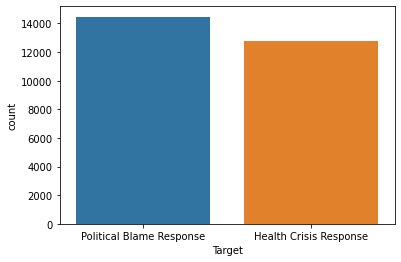

In [19]:
sns.countplot(data=Master_Tweet_dataset,x='Target')

In [22]:
Master_Tweet_dataset.date = pd.to_datetime(Master_Tweet_dataset.date)

<AxesSubplot:xlabel='date'>

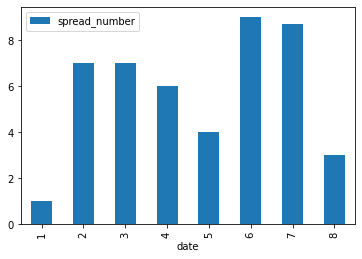

In [29]:
Master_Tweet_dataset[['date','spread_number']].groupby(Master_Tweet_dataset['date'].dt.month).median().plot(kind='bar')

In [27]:
Master_Tweet_dataset["Target_number"] = np.where(Master_Tweet_dataset["Target"].str.contains("Pol"), 1, 0)

<AxesSubplot:xlabel='date'>

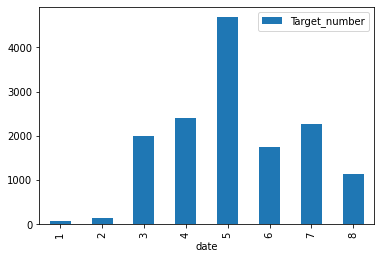

In [28]:
Master_Tweet_dataset[['date','Target_number']].groupby(Master_Tweet_dataset['date'].dt.month).sum().plot(kind='bar')

In [ ]:
#Saving DF for use in other notebooks
pickle.dump(Master_Tweet_dataset,open('pickles/Master_Tweet_datasetfull.pickle','wb'))

## Model Ready DataFrame

To ensure that the data fed to our models is uniform, this last step just dropped columns that were either superflous or contained text that our number-driven models cannot make any use of. For portability, the final dataframe was pickled so that it could be recalled in the Models notebook.

In [ ]:
#dropping columns not applicable for model
Master_Tweet_dataset = Master_Tweet_dataset.drop(['date','username','video','geo','clean_text','Start Date', 
                                                  'End Date','tweet','Sample','replies_count', 'retweets_count',
                                                  'MoE','stopwords','Poll','MoE'],axis=1)

In [ ]:
#Deaths didn't start immediately...filling NAN with 0s for modeling purposes
Master_Tweet_dataset['death'] = Master_Tweet_dataset['death'].fillna(0)
Master_Tweet_dataset.head()

In [ ]:
#Saving DF for use in other notebooks
pickle.dump(Master_Tweet_dataset,open('pickles/Master_Tweet_dataset.pickle','wb'))